# MSCS 634 – Project Deliverable 1  
## Data Collection, Cleaning, and Exploration (EDA)

**Dataset:** `bank-full.csv` (Bank Marketing / Term Deposit Subscription)  
**Objective (Deliverable 1):** Load the dataset, clean/prepare it, and perform exploratory data analysis to uncover insights that will guide later modeling.


In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization (Matplotlib)
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


## 1) Dataset Selection & Description

This dataset contains customer and campaign information from a bank marketing (telemarketing) campaign.  
The target variable is **`y`**, indicating whether the client subscribed to a term deposit (**yes/no**).

**Why this dataset is appropriate:**
- Large enough for robust analysis (**45,211** records)
- Contains a mix of **categorical** and **numeric** attributes (behavioral, demographic, and campaign-related)
- Supports multiple downstream tasks in later deliverables (regression/classification, clustering, and pattern discovery)


In [2]:
# Load dataset (semicolon-separated)
data_path = Path("data") / "bank-full.csv"
df = pd.read_csv(data_path, sep=";")

print("Shape:", df.shape)
df.head()


Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2) Inspect Structure and Basic Quality Checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# Summary statistics for numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


### Missing values, duplicates, and "unknown" coded values

This dataset typically uses the literal string **`"unknown"`** in some categorical fields instead of standard `NaN` missing values.  
We will explicitly quantify:
- true missing values (`NaN`)
- duplicates
- `"unknown"` frequency per column


In [5]:
# True missing values
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0] if (missing > 0).any() else missing.head(10)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
dtype: int64

In [6]:
# Duplicate rows
df.duplicated().sum()

np.int64(0)

In [7]:
# 'unknown' coded values in categorical columns
unknown_counts = (df == "unknown").sum().sort_values(ascending=False)
unknown_counts[unknown_counts > 0]

poutcome     36959
contact      13020
education     1857
job            288
dtype: int64

## 3) Data Cleaning & Preparation

1. **Standardize column names** (lowercase, replace '.' with '_')  
2. **Convert the target** `y` from `'yes'/'no'` to binary `1/0` for easier analysis  
3. **Handle sentinel values** in `pdays`:
   - In this dataset, `pdays = -1` means the client was **not previously contacted**.
   - We convert `-1` to `NaN` and create a new indicator feature **`prev_contacted`**.
4. **Handle `"unknown"` categorical values**
   - We keep `"unknown"` as a valid category (to avoid losing data), **and** we create missing-indicator flags (e.g., `contact_unknown`) so later models can learn from “unknown-ness”.
5. **Type optimization**
   - Convert object (string) columns to `category` to reduce memory and clarify intent.


In [8]:
df_clean = df.copy()

# 1) Standardize column names
df_clean.columns = [c.strip().lower().replace(".", "_") for c in df_clean.columns]

# 2) Target to binary
df_clean["y"] = df_clean["y"].map({"no": 0, "yes": 1}).astype("int8")

# 3) pdays: convert -1 sentinel to NaN + add indicator
df_clean["prev_contacted"] = (df_clean["pdays"] != -1).astype("int8")
df_clean.loc[df_clean["pdays"] == -1, "pdays"] = np.nan

# 4) 'unknown' flags for selected categorical columns
cat_cols = df_clean.select_dtypes(include="object").columns.tolist()
for col in cat_cols:
    if (df_clean[col] == "unknown").any():
        df_clean[f"{col}_unknown"] = (df_clean[col] == "unknown").astype("int8")

# 5) Convert object columns to category
for col in cat_cols:
    df_clean[col] = df_clean[col].astype("category")

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                45211 non-null  int64   
 1   job                45211 non-null  category
 2   marital            45211 non-null  category
 3   education          45211 non-null  category
 4   default            45211 non-null  category
 5   balance            45211 non-null  int64   
 6   housing            45211 non-null  category
 7   loan               45211 non-null  category
 8   contact            45211 non-null  category
 9   day                45211 non-null  int64   
 10  month              45211 non-null  category
 11  duration           45211 non-null  int64   
 12  campaign           45211 non-null  int64   
 13  pdays              8257 non-null   float64 
 14  previous           45211 non-null  int64   
 15  poutcome           45211 non-null  category
 16  y   

In [15]:
# Post-cleaning check: missing values and a quick preview
df_clean.isna().sum().sort_values(ascending=False).head(10), df_clean.head()

(pdays        36954
 age              0
 marital          0
 education        0
 default          0
 job              0
 balance          0
 housing          0
 contact          0
 loan             0
 dtype: int64,
    age           job  marital  education default  balance housing loan  \
 0   58    management  married   tertiary      no     2143     yes   no   
 1   44    technician   single  secondary      no       29     yes   no   
 2   33  entrepreneur  married  secondary      no        2     yes  yes   
 3   47   blue-collar  married    unknown      no     1506     yes   no   
 4   33       unknown   single    unknown      no        1      no   no   
 
    contact  day  ... campaign  pdays  previous  poutcome  y prev_contacted  \
 0  unknown    5  ...        1    NaN         0   unknown  0              0   
 1  unknown    5  ...        1    NaN         0   unknown  0              0   
 2  unknown    5  ...        1    NaN         0   unknown  0              0   
 3  unknown    5 

## 4) Exploratory Data Analysis (EDA)

We explore:
- **Target distribution** (class imbalance)
- **Distributions** of numeric variables
- **Outliers** (boxplots/IQR intuition)
- **Relationships** between features and target (`y`)
- **Correlations** among numeric predictors


,count,percent
y,,
0,39922,88.3
1,5289,11.7


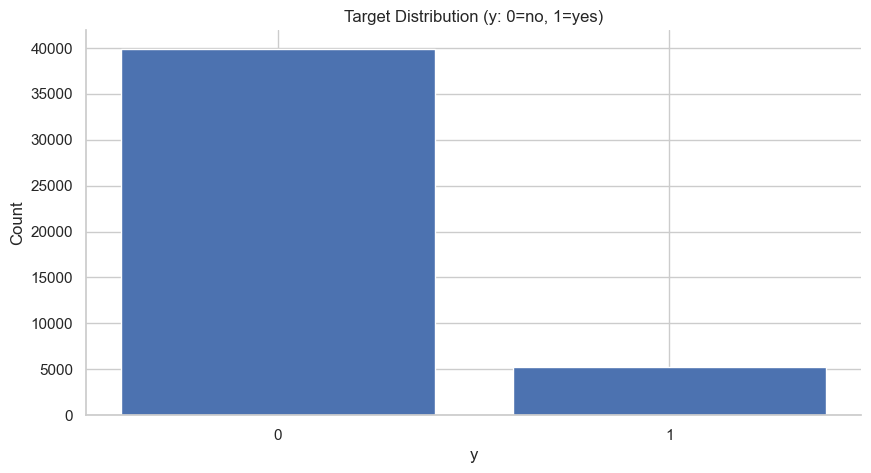

In [42]:
# Target distribution
target_counts = df_clean["y"].value_counts()
target_pct = df_clean["y"].value_counts(normalize=True) * 100
display(pd.DataFrame({"count": target_counts, "percent": target_pct.round(2)}))

plt.figure()
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution (y: 0=no, 1=yes)")
plt.xlabel("y")
plt.ylabel("Count")
plt.savefig("target_distribution.png", dpi=300, bbox_inches='tight') 

plt.show()


### Numeric feature distributions

Saved: numeric_dist_age.png


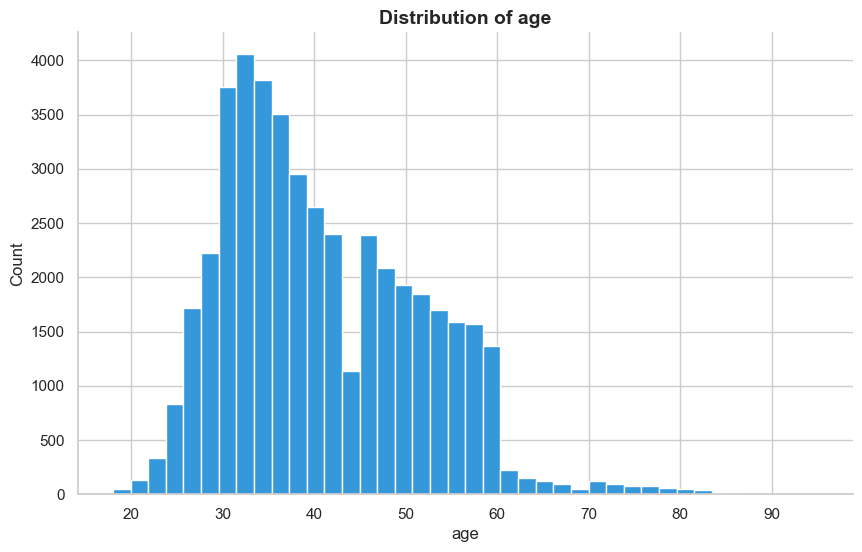

Saved: numeric_dist_balance.png


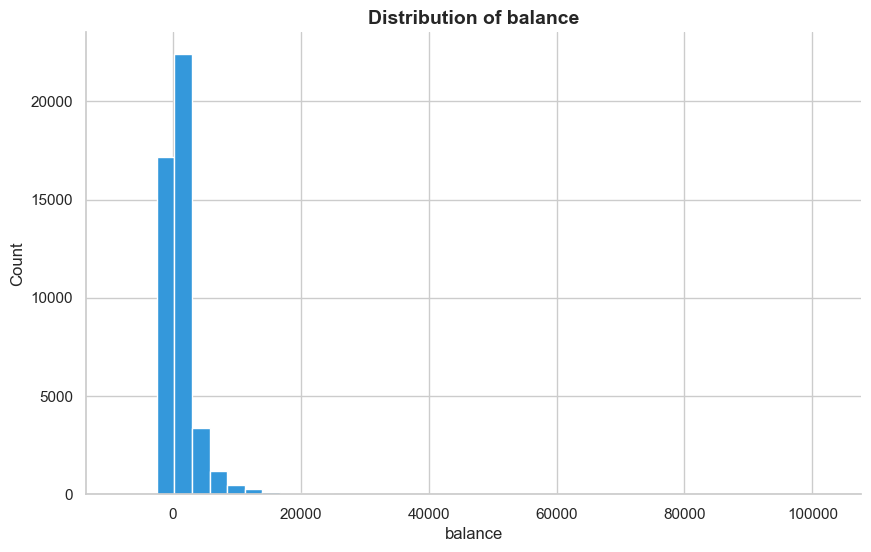

Saved: numeric_dist_duration.png


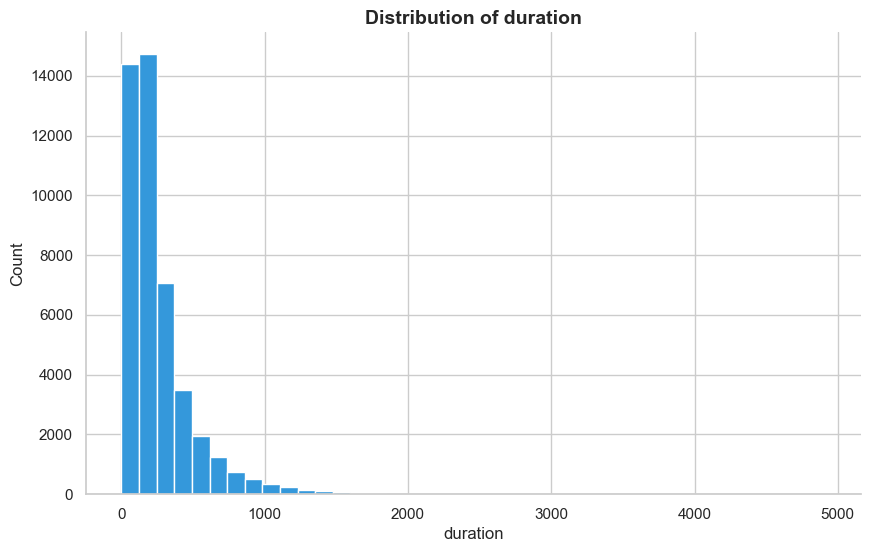

Saved: numeric_dist_campaign.png


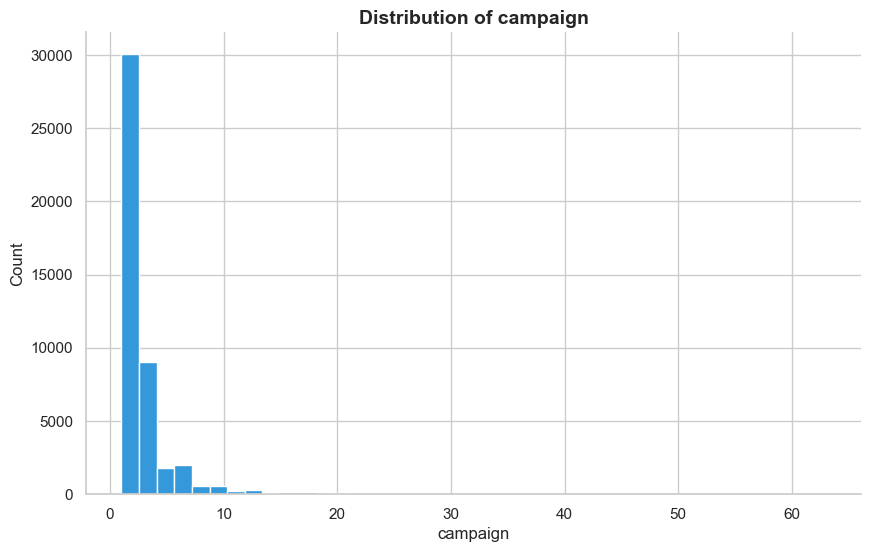

Saved: numeric_dist_pdays.png


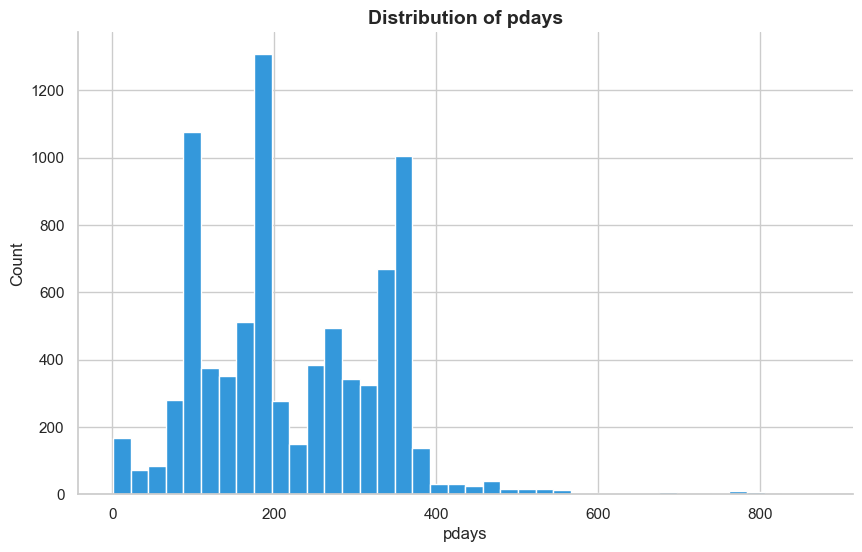

Saved: numeric_dist_previous.png


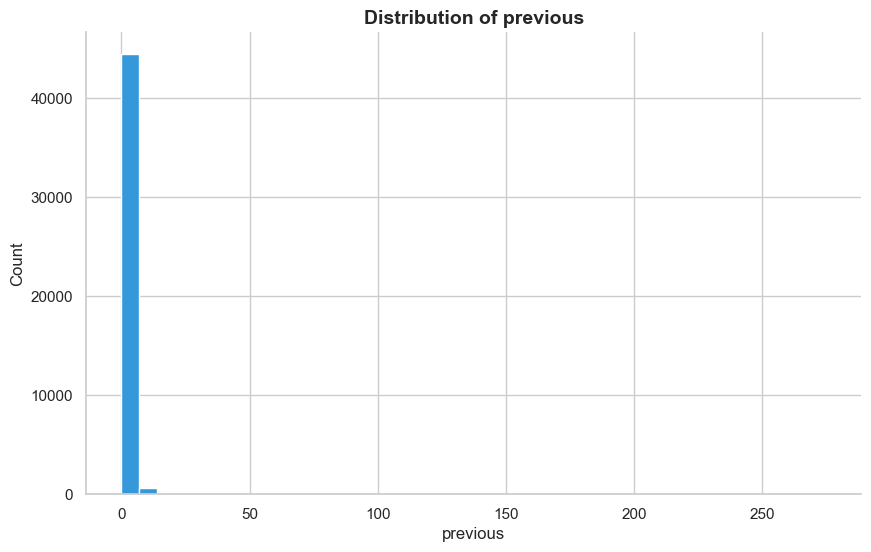

Saved: numeric_dist_day.png


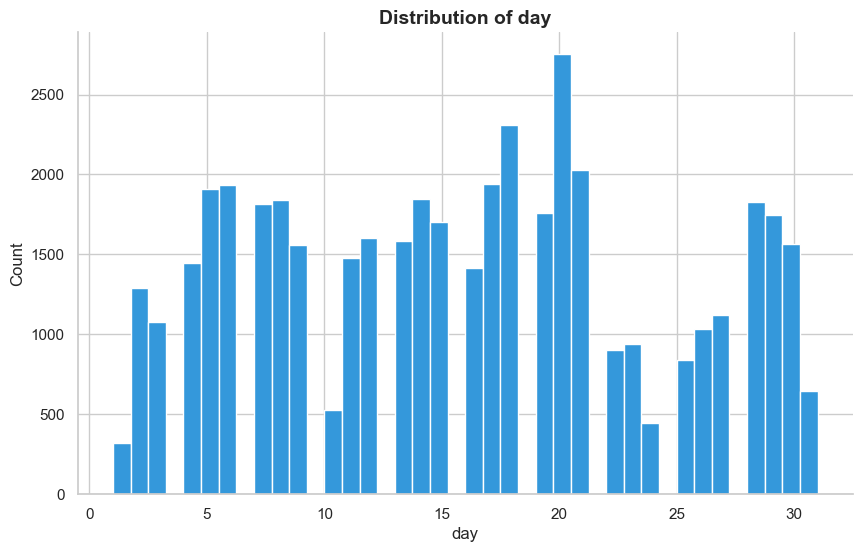

In [43]:
num_cols = ["age", "balance", "duration", "campaign", "pdays", "previous", "day"]

for col in num_cols:
    data = df_clean[col].dropna().to_numpy()
    
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=40, color='#3498db', edgecolor='white')
    
    plt.title(f"Distribution of {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel("Count")
    
    # FIX: This puts the column name in the filename and ends with .png
    filename = f"numeric_dist_{col}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    print(f"Saved: {filename}") # Helpful to see progress
    plt.show()


### Outliers (boxplots)

Bank marketing data often has:
- highly skewed **balance** (with both negative and very large positive values)
- long-tailed **duration** and **campaign** counts

We **do not remove** these outliers in Deliverable 1; instead, we document them and consider robust transforms later.


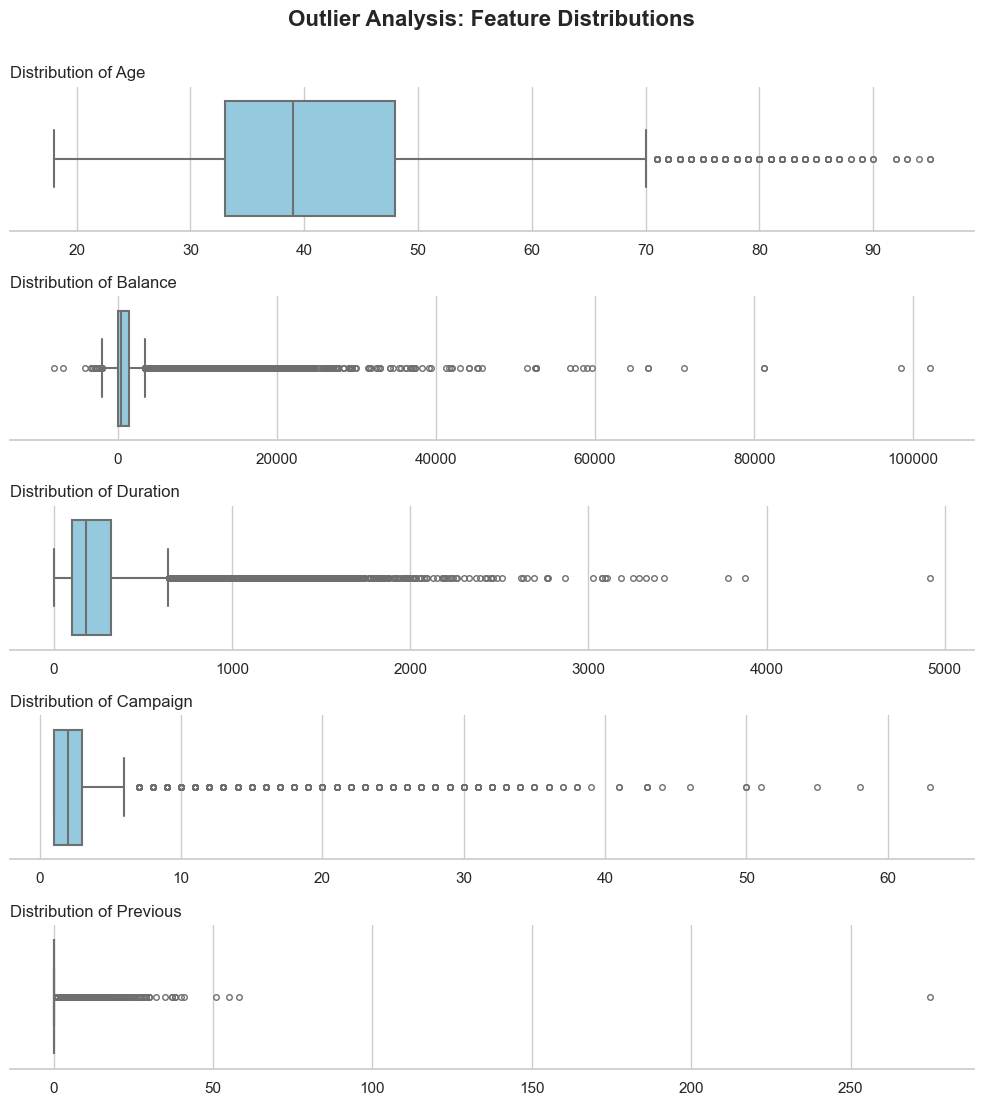

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set_theme(style="whitegrid")

cols = ["age", "balance", "duration", "campaign", "previous"]

# Create a figure with subplots (5 rows, 1 column)
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(10, 12))
fig.suptitle("Outlier Analysis: Feature Distributions", fontsize=16, fontweight='bold', y=0.95)

for i, col in enumerate(cols):
    # Plotting with Seaborn for better styling
    sns.boxplot(x=df_clean[col], ax=axes[i], color="skyblue", fliersize=4, linewidth=1.5)
    
    # Refining labels and removing clutter
    axes[i].set_title(f"Distribution of {col.capitalize()}", loc='left', fontsize=12)
    axes[i].set_xlabel("")
    axes[i].spines[['top', 'right', 'left']].set_visible(False)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save with high resolution
plt.savefig("outlier_boxplots.png", dpi=300, bbox_inches='tight')

plt.show()

### Categorical distributions

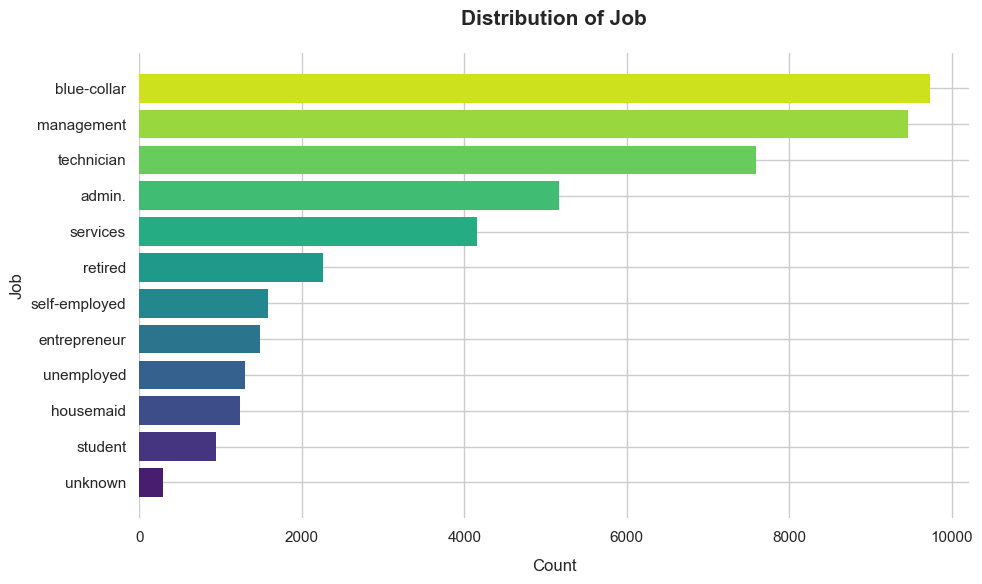

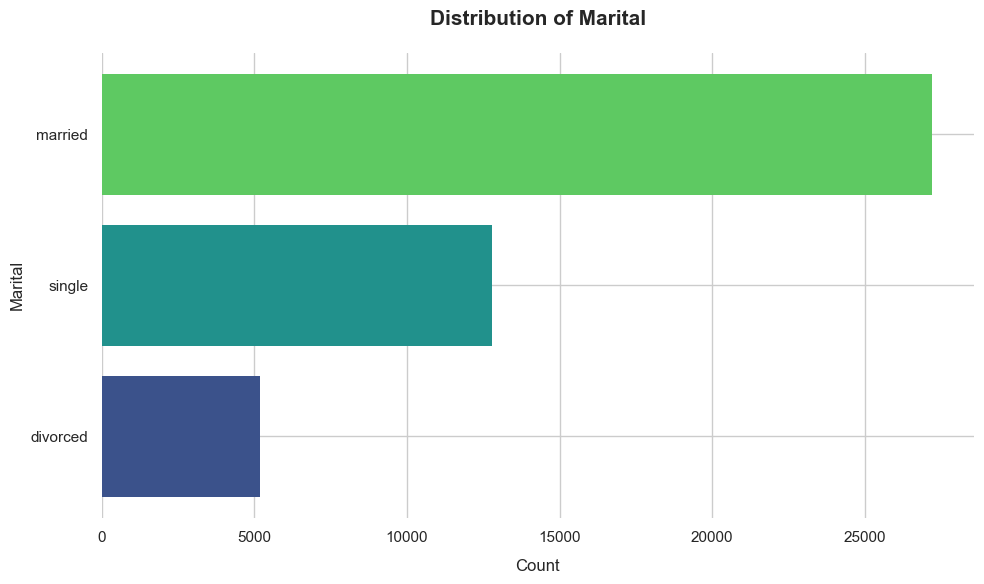

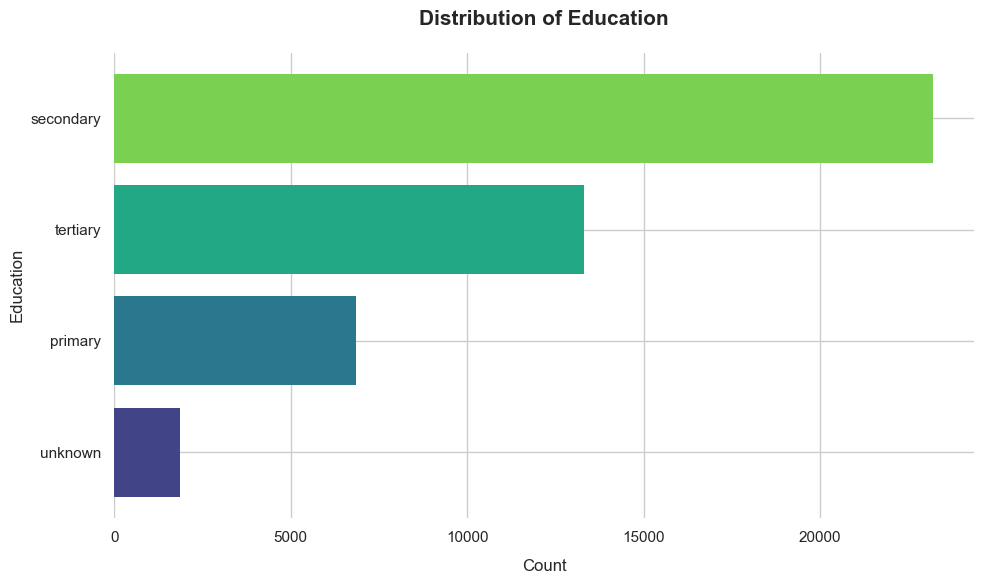

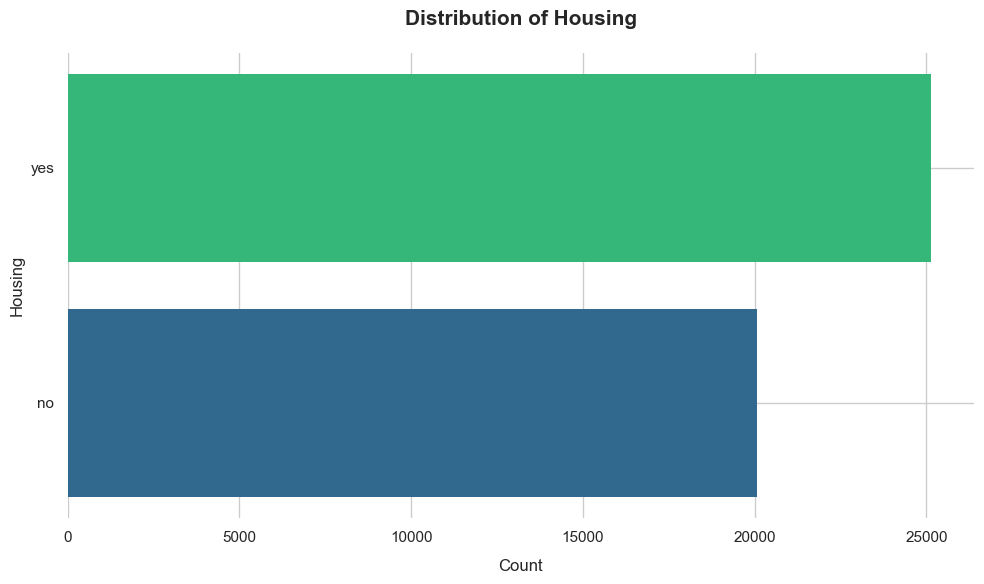

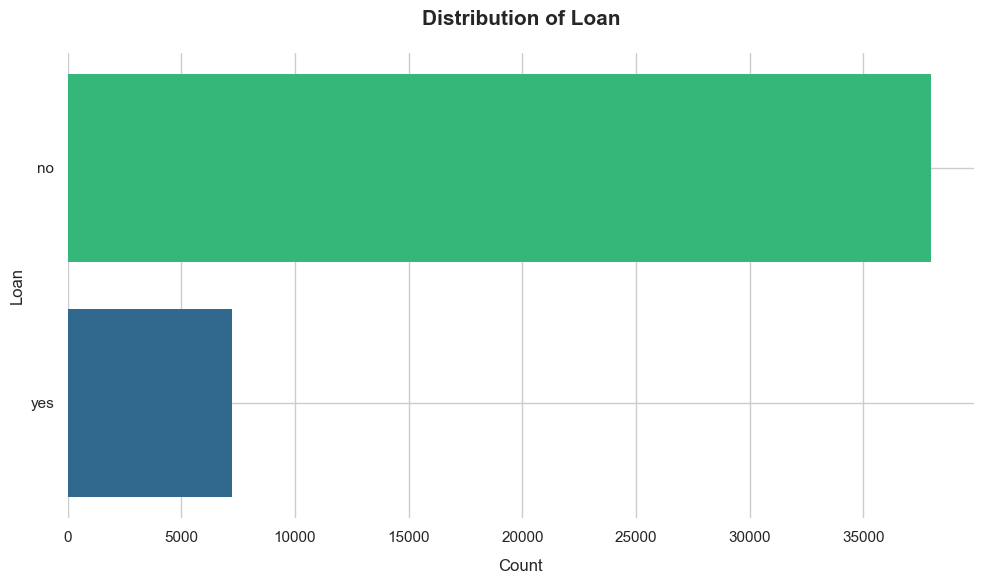

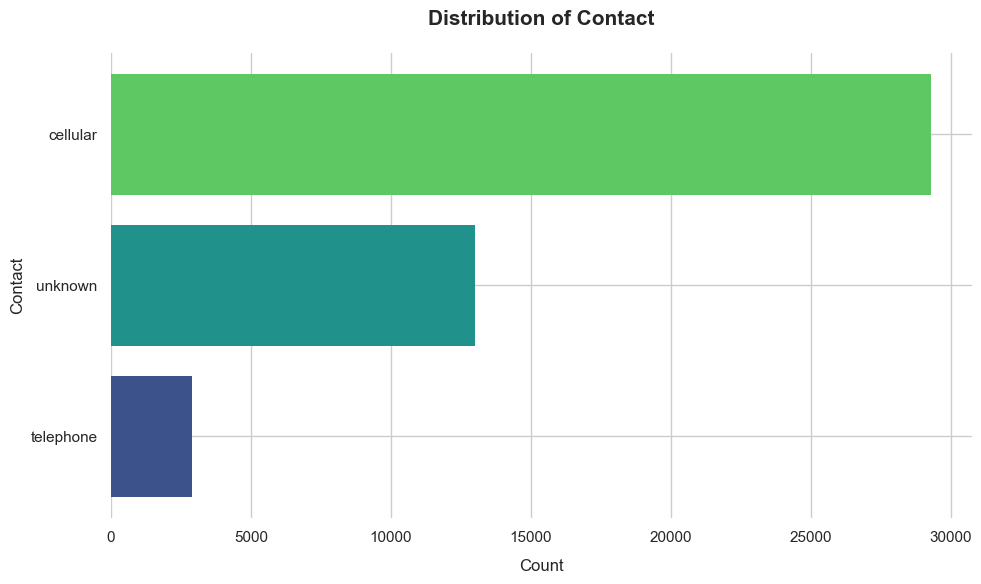

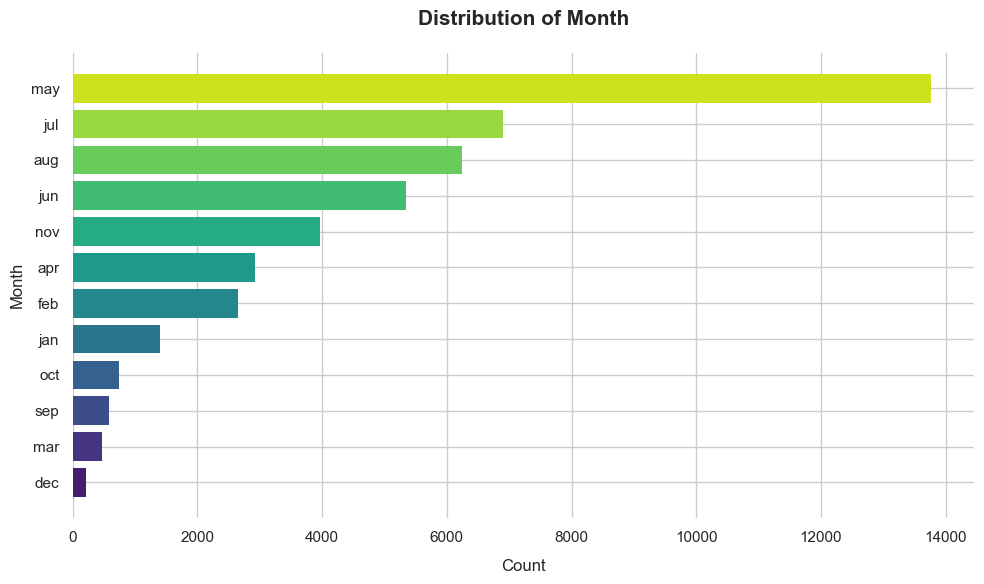

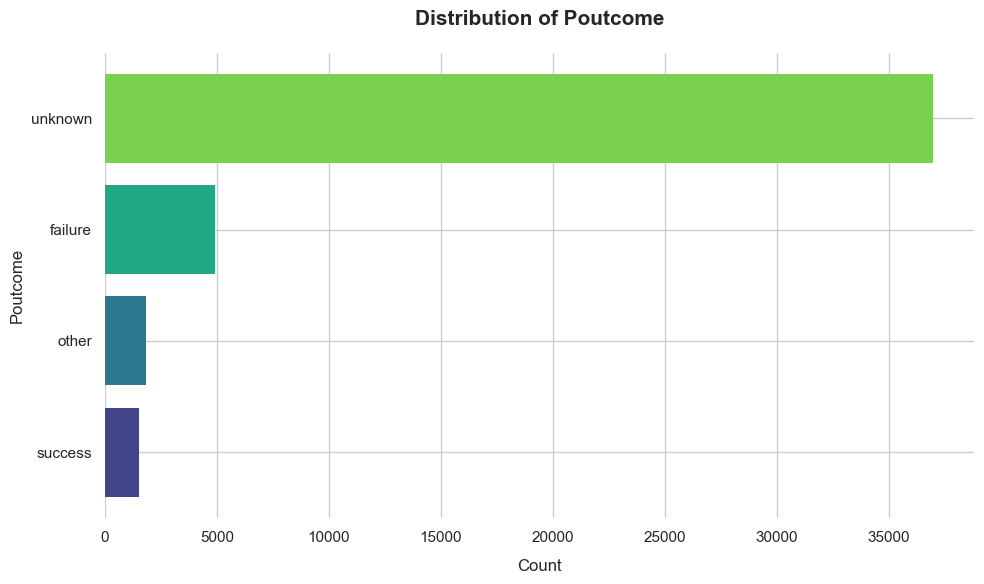

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Sets a clean, professional aesthetic
sns.set_theme(style="whitegrid")

cat_show = ["job", "marital", "education", "housing", "loan", "contact", "month", "poutcome"]

for col in cat_show:
    # Get counts and sort
    counts = df_clean[col].value_counts().sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    
    # Use a nice color palette and create the horizontal bar
    colors = sns.color_palette("viridis", len(counts))
    plt.barh(counts.index.astype(str), counts.values, color=colors, edgecolor='none')
    
    # Clean up the look
    plt.title(f"Distribution of {col.title()}", fontsize=15, fontweight='bold', pad=20)
    plt.xlabel("Count", fontsize=12, labelpad=10)
    plt.ylabel(col.title(), fontsize=12)
    
    # Remove the top and right spines for a modern "open" feel
    sns.despine(left=True, bottom=True)
    plt.savefig("categorical_distribution_"+col+".png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

## 5) Feature Target Relationships

We examine:
- Numeric variables vs target (box/violin)
- Categorical variables vs target (subscription rate by category)

This helps identify **strong predictors** and potential **data leakage** risks.


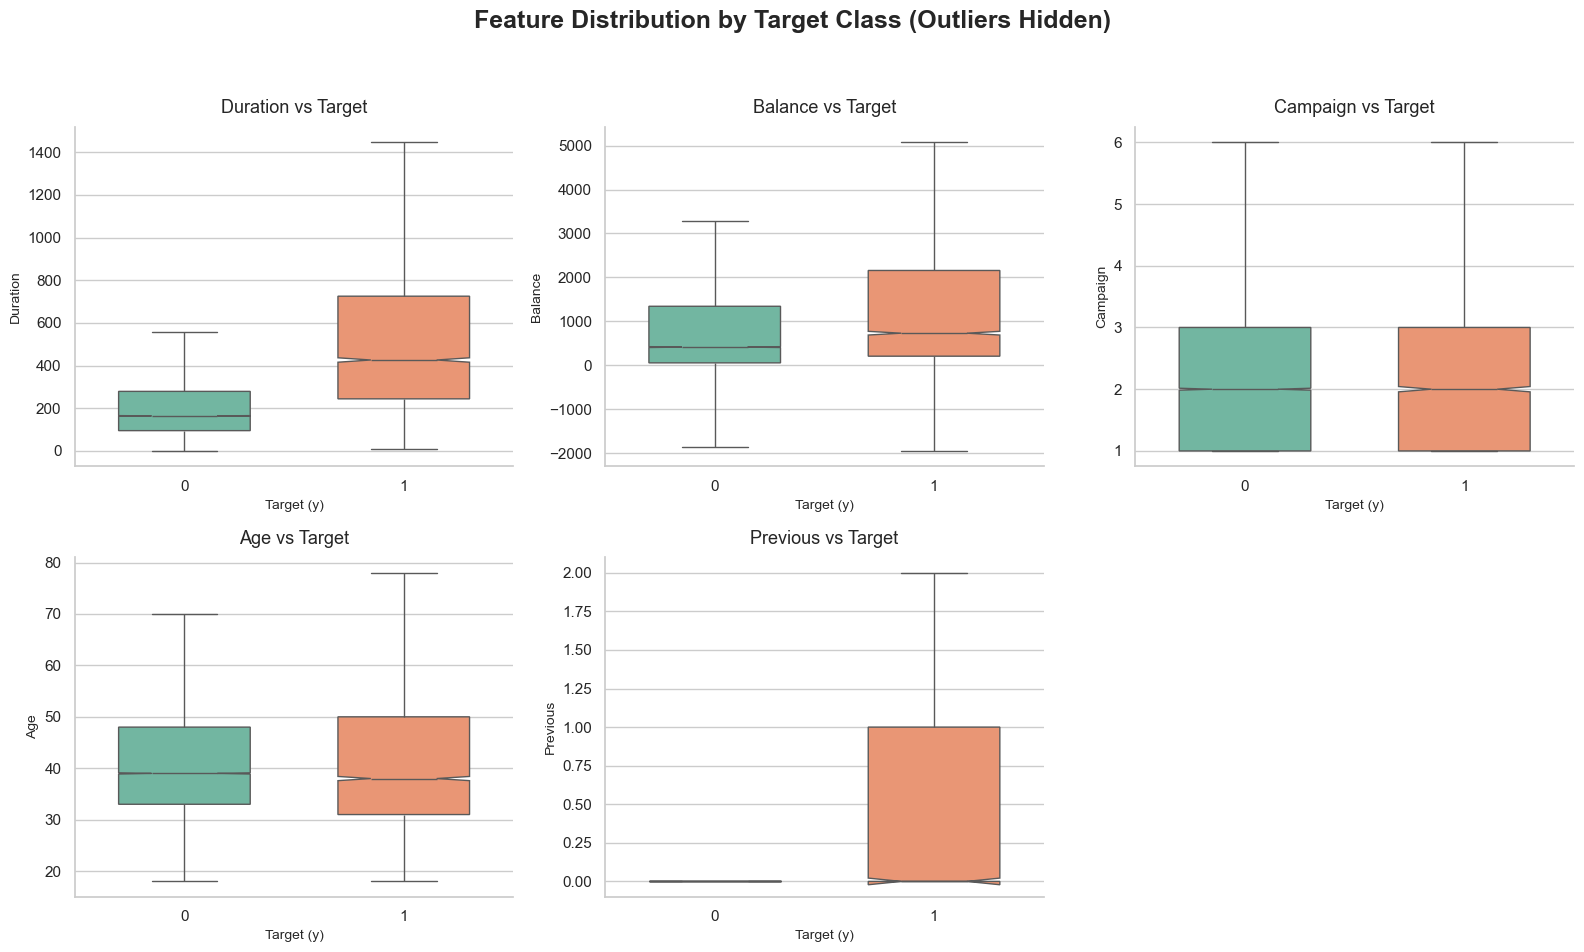

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup the aesthetic style
sns.set_theme(style="whitegrid")

# Define columns (ensure df_clean exists in your environment)
cols = ["duration", "balance", "campaign", "age", "previous"]

# Create a figure with a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten() # Flatten to iterate easily

# Main title
fig.suptitle("Feature Distribution by Target Class (Outliers Hidden)", 
             fontsize=18, fontweight='bold', y=0.98)

for i, col in enumerate(cols):
    # Fixed: Passing 'hue' and 'legend' to resolve FutureWarning
    sns.boxplot(
        x='y', 
        y=col, 
        data=df_clean, 
        ax=axes[i],
        hue='y',           # Explicitly link colors to the 'y' variable
        legend=False,      # Prevents redundant legends on every subplot
        palette="Set2",
        showfliers=False,  # Keep your preference for readability
        notch=True,        # Adds a visual cue for median significance
        width=0.6
    )
    
    # Cleaning up the individual subplots
    axes[i].set_title(f"{col.capitalize()} vs Target", fontsize=13, pad=10)
    axes[i].set_xlabel("Target (y)", fontsize=10)
    axes[i].set_ylabel(col.capitalize(), fontsize=10)
    axes[i].spines[['top', 'right']].set_visible(False)

# Remove the unused 6th subplot (since we only have 5 features)
if len(cols) < len(axes):
    fig.delaxes(axes[-1])

# Fine-tune layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save at high resolution
plt.savefig("numeric_vs_target_boxplots.png", dpi=300, bbox_inches='tight')

plt.show()

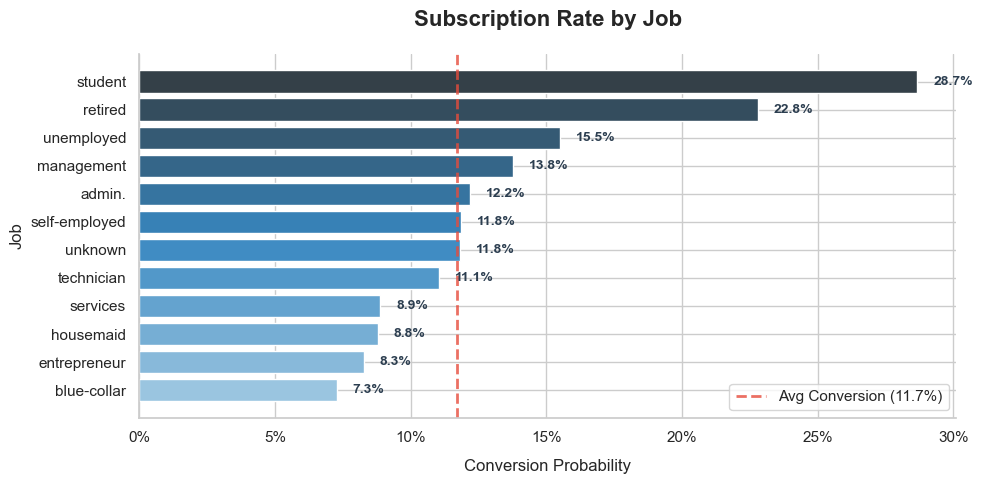

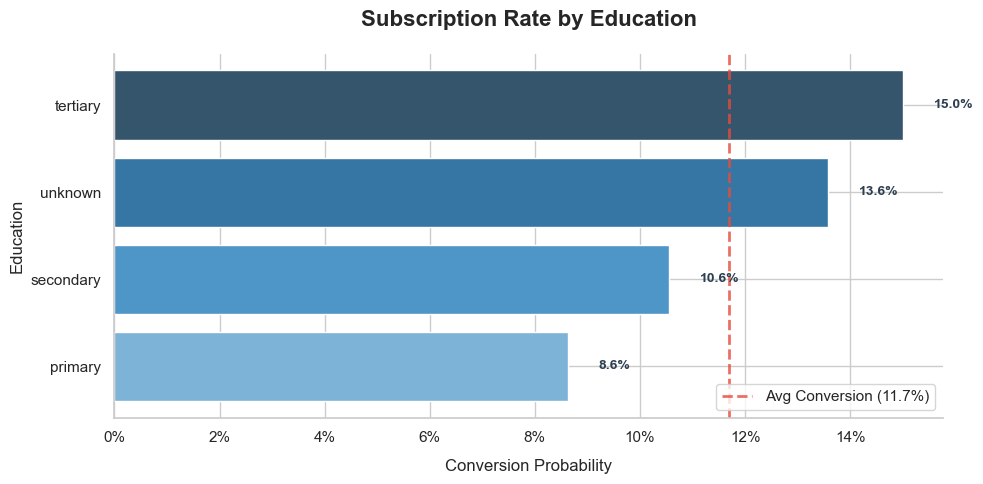

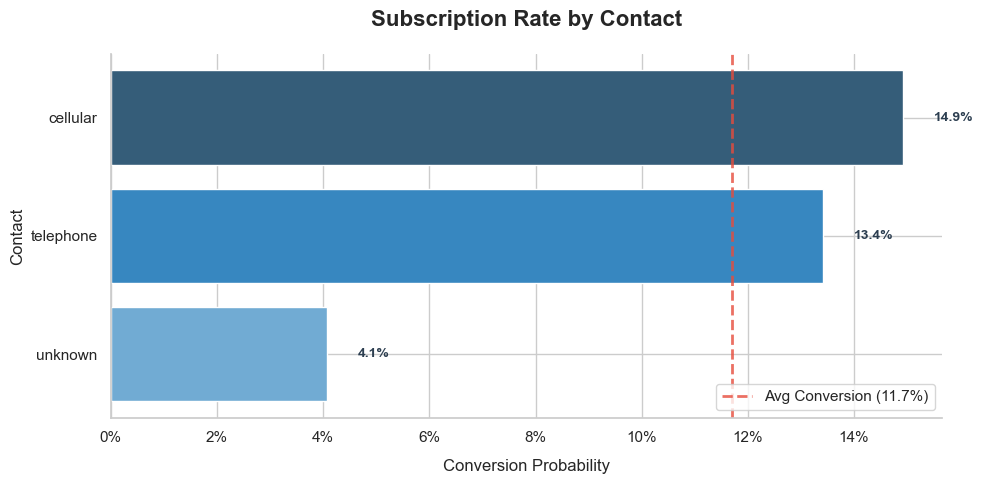

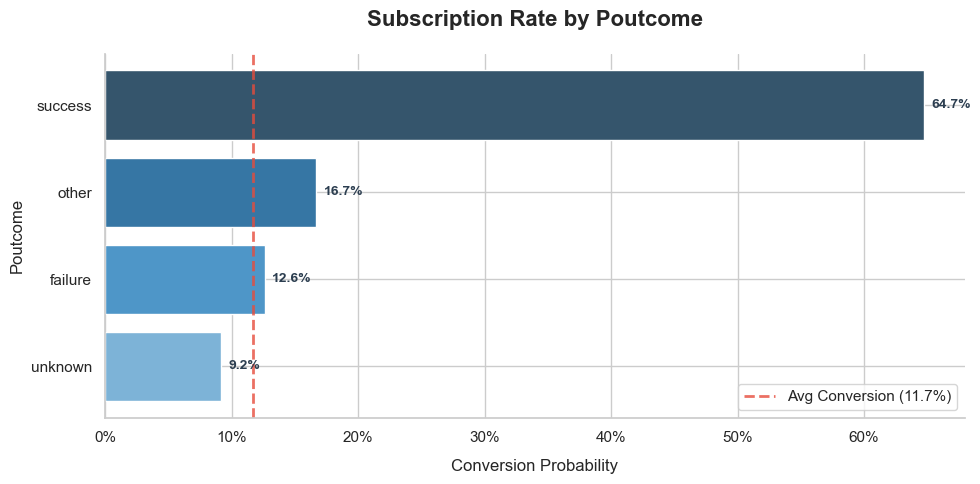

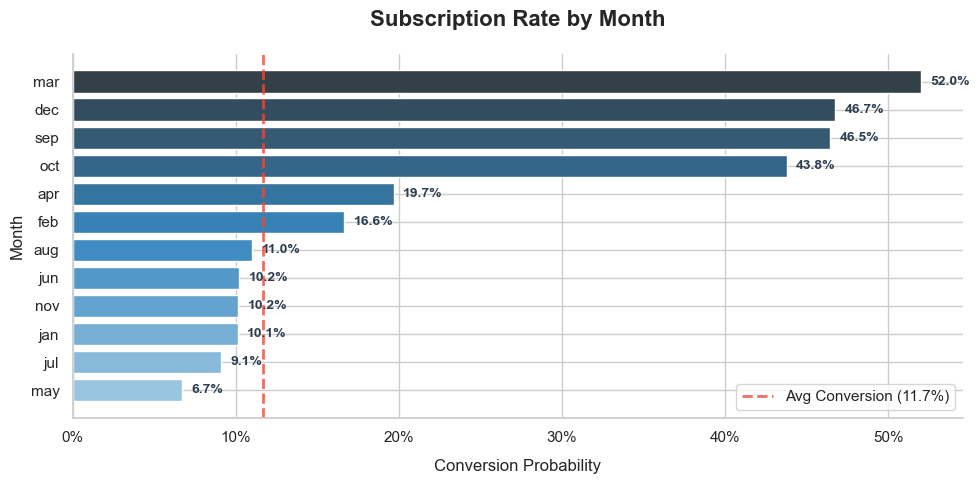

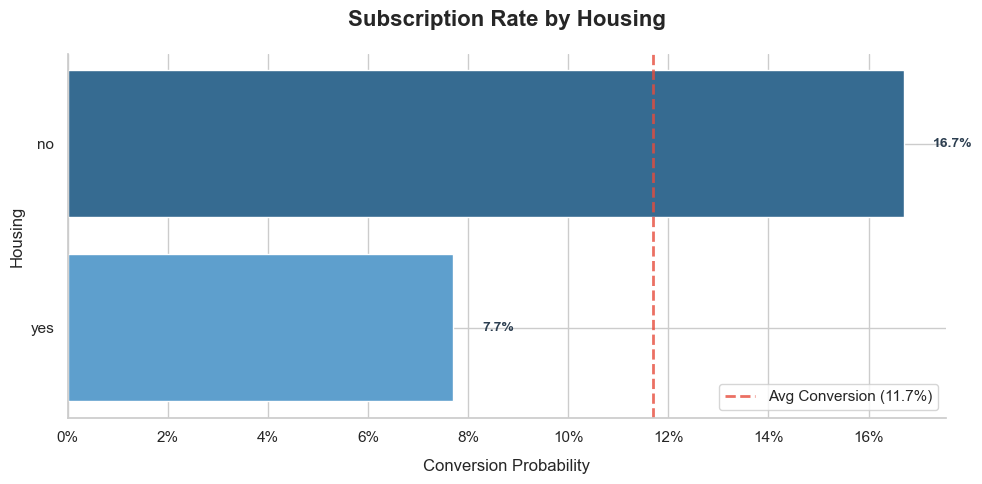

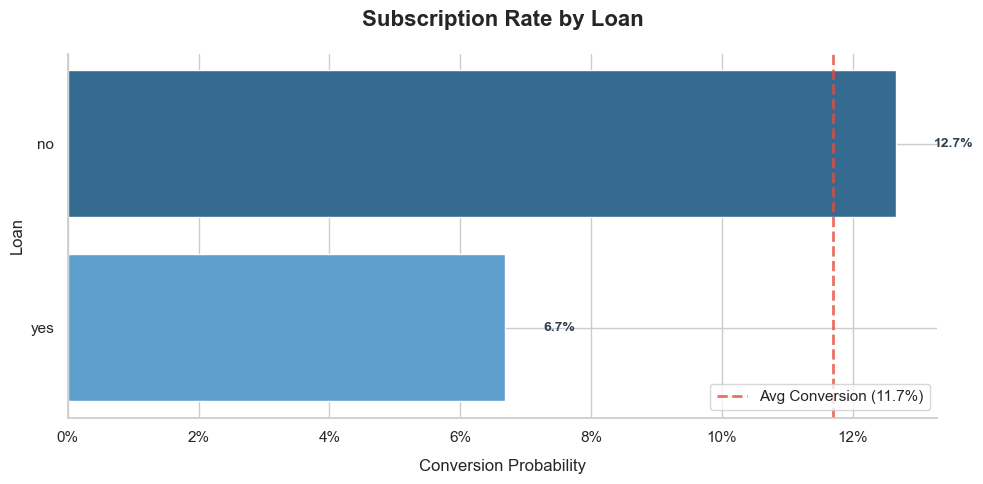

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Global styling
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100  # Makes plots sharper
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

def plot_target_rate(df, col, target='y', top_n=15):
    """
    Plots the mean of the target variable (conversion rate) per category.
    Includes a baseline average line and percentage formatting.
    """
    # Fix for FutureWarning: added observed=False
    # We calculate the mean of the target 'y' grouped by the category 'col'
    rates = df.groupby(col, observed=False)[target].mean().sort_values(ascending=True)
    
    # Limit to top_n if there are too many categories
    if len(rates) > top_n:
        rates = rates.tail(top_n)

    # Calculate global mean for baseline comparison
    overall_mean = df[target].mean()

    # Initialize the plot
    plt.figure(figsize=(10, 5))
    
    # Create horizontal bar chart
    # Use a color palette for visual appeal
    colors = sns.color_palette("Blues_d", len(rates))
    bars = plt.barh(rates.index.astype(str), rates.values, color=colors)
    
    # Add a dashed line for the overall average subscription rate
    plt.axvline(overall_mean, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8, 
                label=f'Avg Conversion ({overall_mean:.1%})')
    
    # Formatting and Titles
    plt.title(f"Subscription Rate by {col.title()}", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Conversion Probability", fontsize=12, labelpad=10)
    plt.ylabel(col.title(), fontsize=12)
    plt.legend(loc='lower right', frameon=True, facecolor='white')
    
    # Format X-axis as percentage (e.g., 0.1 -> 10%)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    # Add data labels (percentage) at the end of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + (overall_mean * 0.05), # Small offset
                 bar.get_y() + bar.get_height()/2, 
                 f'{width:.1%}', 
                 va='center', fontsize=10, fontweight='bold', color='#2c3e50')

    plt.tight_layout()
    plt.savefig("subscription_rate_by"+col+".png", dpi=300, bbox_inches='tight')
    plt.show()

target_cols = ["job", "education", "contact", "poutcome", "month", "housing", "loan"]

for col in target_cols:
    if col in df_clean.columns:
        plot_target_rate(df_clean, col)
    else:
        print(f"Column '{col}' not found in dataframe.")

### Numeric correlations (Pearson)

Note: Correlation is computed only among numeric variables (after our light cleaning).

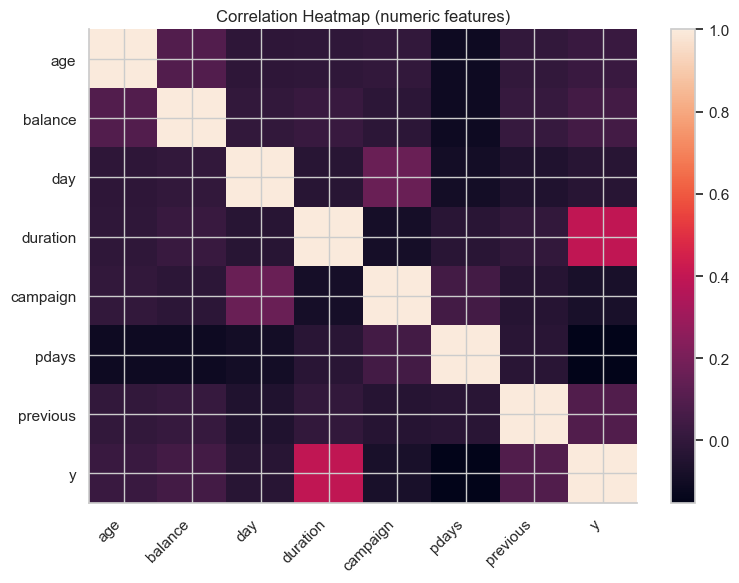

In [ ]:
num_for_corr = df_clean[["age", "balance", "day", "duration", "campaign", "pdays", "previous", "y"]]
corr = num_for_corr.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

corr